In [3]:
%reload_ext autoreload
%autoreload 2

In [33]:
import autorootcwd
import os

import torch

from src.models.crnn import get_model
from src.utils import get_torch_device, id_to_chord_map, get_chord_annotation, HOP_LENGTH, SR

frame_to_secs = lambda x: round(x * (HOP_LENGTH / SR), 2)

def chord_frames_to_sequence(pred_classes):
    """
    Given a list of chord IDs (one per frame), returns a list of
    (chord, start_time_sec, end_time_sec) tuples, where:
      - start_time_sec = frame_to_secs(start_frame)
      - end_time_sec   = frame_to_secs(end_frame)
    """

    chords = []
    start_frame = 0
    n_frames = len(pred_classes)

    # Edge case: if no frames, return empty
    if n_frames == 0:
        return chords

    # Iterate until the second-to-last frame
    for i in range(n_frames - 1):
        c = pred_classes[i]
        # If the chord changes at the next frame, or we are at the last iteration:
        if c != pred_classes[i + 1]:
            # The chord c spanned from start_frame..i (inclusive).
            # We'll consider the chord region to end right after frame i => i+1
            chords.append(
                (c, frame_to_secs(start_frame), frame_to_secs(i + 1))
            )
            # Next chord region starts at i+1
            start_frame = i + 1

    # Handle the final chord, spanning from start_frame..(n_frames)
    last_chord = pred_classes[-1]
    chords.append(
        (last_chord, frame_to_secs(start_frame), frame_to_secs(n_frames))
    )

    return chords

In [28]:
model = get_model(hmm=False)
model_smooth = get_model(hmm=True, hmm_alpha=0.2)
device = get_torch_device()
DIR = 'data/processed'
filename = "raycharles_eleanorrigby"
cqt = torch.load(f"{DIR}/cache/4096/cqts/{filename}.pt", weights_only=True) 

In [31]:
preds = model.predict(cqt.unsqueeze(0).to(device)).squeeze()
preds_smooth = model_smooth.predict(cqt.unsqueeze(0).to(device)).squeeze()
true_chords = get_chord_annotation(filename, frame_length=HOP_LENGTH/SR)

In [32]:
def to_seq(seq):
    if torch.is_tensor(seq):
        seq = seq.squeeze().cpu().numpy()
    # Convert to chord ids
    seq_chords = [id_to_chord_map[c] for c in seq]
    # Convert to chord sequence
    seq = chord_frames_to_sequence(seq_chords)
    return seq

preds_seq = to_seq(preds)
preds_smooth_seq = to_seq(preds_smooth)
true_chords_seq = to_seq(true_chords)

preds_seq, preds_smooth_seq, true_chords_seq

([('E:min', 0.0),
  ('N', 0.19),
  ('E:min', 0.28),
  ('C:maj7', 4.37),
  ('E:min', 4.46),
  ('C:maj', 9.2),
  ('C:7', 9.29),
  ('C:maj', 9.94),
  ('C:7', 11.52),
  ('C:maj7', 11.8),
  ('E:min', 13.1),
  ('C:maj', 17.55),
  ('C:7', 18.02),
  ('C:maj', 18.85),
  ('C:7', 18.95),
  ('D#:dim7', 19.69),
  ('C:7', 19.88),
  ('C:maj7', 20.25),
  ('E:min', 21.36),
  ('E:min7', 21.73),
  ('E:min', 23.31),
  ('E:min7', 23.41),
  ('E:min', 23.5),
  ('E:min6', 24.89),
  ('E:min', 25.73),
  ('C:maj7', 25.91),
  ('E:min', 26.38),
  ('C:maj', 26.94),
  ('E:min', 27.86),
  ('E:min7', 29.72),
  ('E:min', 31.39),
  ('E:min6', 33.81),
  ('E:min', 34.09),
  ('C:maj7', 34.64),
  ('C:maj', 36.04),
  ('C:maj7', 36.22),
  ('E:min', 36.5),
  ('C:maj7', 37.52),
  ('E:min', 37.89),
  ('C:maj7', 37.99),
  ('C:maj', 38.17),
  ('C:7', 38.36),
  ('C:maj7', 42.35),
  ('E:min', 43.1),
  ('A:min7', 46.44),
  ('A:min', 48.39),
  ('A:7', 49.69),
  ('A:min', 49.78),
  ('E:min', 50.9),
  ('C:maj7', 59.16),
  ('C:maj', 59.3

### Make it Pretty!

In [41]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import random
from matplotlib.ticker import FuncFormatter

from src.utils import chord_to_id, id_to_chord, chord_to_id_map

##############################################################################
# 1) Utility to convert from large-vocab ID to small-vocab ID
##############################################################################
@lru_cache(maxsize=None)
def large_to_small_vocab_id(ch_id: int) -> int:
    """
    Converts a large vocabulary chord id to a small vocabulary chord id.
    """
    chord = id_to_chord(ch_id, use_small_vocab=False)
    return chord_to_id(chord, use_small_vocab=True)

##############################################################################
# 2) Helper function to clip chord intervals to [start_time, end_time],
#    but do NOT shift times (i.e., no rebase).
##############################################################################
def slice_chords_no_rebase(chords, start_time, end_time):
    """
    chords: list of (chord_id, chord_abs_start)

    Convert each chord to (chord_id, chord_abs_start, chord_abs_end),
    and clip to [start_time, end_time], but do NOT shift times to zero.
    """
    intervals = []
    for i, (cid, cstart) in enumerate(chords):
        # End time from next chord or +2 if last
        if i < len(chords) - 1:
            cend = chords[i + 1][1]
        else:
            cend = cstart + 2.0

        # Overlap with [start_time, end_time]?
        if cend >= start_time and cstart <= end_time:
            clipped_start = max(cstart, start_time)
            clipped_end   = min(cend, end_time)
            if clipped_end > clipped_start:
                intervals.append((cid, clipped_start, clipped_end))
    return intervals

def slice_intervals_for_window(intervals, window_start, window_end):
    """
    intervals: list of (chord_id, chord_abs_start, chord_abs_end)
    Returns only the portion of each interval overlapping [window_start, window_end].
    """
    clipped = []
    for (cid, st, en) in intervals:
        # Check overlap
        if en >= window_start and st <= window_end:
            cst = max(st, window_start)
            cen = min(en, window_end)
            if cen > cst:
                clipped.append((cid, cst, cen))
    return clipped

##############################################################################
# 3) Main plotting function
##############################################################################
def plot_chord_block(
    chord_sequences_dict,
    window=None,
    title=None,
    width_per_second=0.4,
    draw_chord_change_lines=True,
    save_as=None,
    seed=0
):
    """
    chord_sequences_dict: { "True": [tensor-or-list-of-frame-chords], "Predicted": [...], ... }
      - Each entry is a sequence of per-frame chord IDs (or a torch tensor).
    window: (start_t, end_t) to clip & display. We do NOT shift times to zero.
    title: optional plot title
    width_per_second: figure width scale factor per second in the timeline
    draw_chord_change_lines: whether to draw vertical lines for chord changes in the FIRST sequence
    save_as: optional file name prefix to save PNG
    seed: random seed to shuffle the color palette
    """

    ###########################################################################
    # A) Convert frame-level chord data -> (cid, start_sec, end_sec) intervals
    ###########################################################################
    new_chord_sequences_dict = {}
    for label, seq in chord_sequences_dict.items():
        # 1) If seq is a torch tensor, convert to numpy
        if torch.is_tensor(seq):
            seq = seq.squeeze().cpu().numpy()

        # 2) Convert numeric chord IDs to chord *names* (or pass as-is, depending on your code).
        #    For example, if your 'seq' is already small or large chord IDs, you might do:
        #    seq_chords = [id_to_chord_map[c] for c in seq]
        #    But let's assume we want to keep them as numeric IDs for chord_frames_to_sequence:
        seq_chords = seq  # if you want to keep them numeric, directly

        # 3) Convert frames -> intervals with REAL end times
        seq_intervals = chord_frames_to_sequence(seq_chords)

        new_chord_sequences_dict[label] = seq_intervals

    chord_sequences_dict = new_chord_sequences_dict

    ###########################################################################
    # B) Create color palette (for small-vocab chord IDs)
    ###########################################################################
    NUM_SMALL_CHORDS = 26
    perm = list(range(NUM_SMALL_CHORDS))
    random.seed(seed)
    random.shuffle(perm)

    colors_26 = []
    for i in range(NUM_SMALL_CHORDS):
        j = perm[i]
        hue = j / NUM_SMALL_CHORDS
        s = 0.5
        v = 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, s, v)
        # 50% alpha face color
        colors_26.append((r, g, b, 0.5))

    def get_small_vocab_color(large_id: int):
        """
        Example: Convert a 'large' chord ID to a 'small' one, then pick from colors_26.
        If you have a direct mapping, adapt accordingly.
        """
        sv_id = large_to_small_vocab_id(large_id)
        return colors_26[sv_id]

    ###########################################################################
    # C) Determine x_min, x_max from the intervals (unless 'window' is given)
    ###########################################################################
    # The first sequence is used for chord-change lines, so let's identify it
    labels_in_order = list(chord_sequences_dict.keys())
    if not labels_in_order:
        print("No chord data in chord_sequences_dict.")
        return

    first_label = labels_in_order[0]
    first_seq   = chord_sequences_dict[first_label]  # each item is (cid, st, en)

    if window is not None:
        # If user provided window, trust that
        x_min, x_max = window
    else:
        # Derive from chord data
        starts_ends = []
        for intervals in chord_sequences_dict.values():
            for (cid, st, en) in intervals:
                starts_ends.append(st)
                starts_ends.append(en)
        if not starts_ends:
            print("No chord data!")
            return
        x_min = min(starts_ends)
        x_max = max(starts_ends)

    window_length = x_max - x_min
    if window_length <= 0:
        print("No valid window to display: end <= start.")
        return

    ###########################################################################
    # D) Clip each sequence of intervals to [x_min, x_max] if needed
    ###########################################################################
    tracks = []
    for label, intervals in chord_sequences_dict.items():
        if window is not None:
            clipped = slice_intervals_for_window(intervals, x_min, x_max)
        else:
            clipped = intervals
        tracks.append((label, clipped))

    ###########################################################################
    # E) Plot
    ###########################################################################
    num_tracks = len(tracks)
    fig_width  = max(1.0, width_per_second * window_length)
    fig_height = 1.5 * num_tracks
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    def plot_chord_rectangles(chords_3col, y_base, x_left, ax, label_text=None):
        """
        chords_3col: list of (chord_id, start_sec, end_sec)
        y_base: bottom of rectangle track
        x_left: used for label placement
        """
        for (cid, st, en) in chords_3col:
            width = en - st
            color = get_small_vocab_color(cid)
            # Draw a rectangle
            rect = Rectangle(
                (st, y_base),
                width,
                1.0,
                edgecolor=(0, 0, 0, 1.0),
                facecolor=color
            )
            ax.add_patch(rect)

            # Optionally label chord if wide enough
            if width >= 0.8:
                chord_name = id_to_chord_map[cid]
                ax.text(
                    st + width/2,
                    y_base + 0.5,
                    chord_name,
                    ha='center',
                    va='center'
                )

        if label_text is not None:
            ax.text(
                x_left - 0.2,
                y_base + 0.5,
                label_text,
                ha='right',
                va='center',
                style='italic'
            )

    # Plot each track from top (0) down
    for i, (label, intervals) in enumerate(tracks):
        y_base = -i
        plot_chord_rectangles(intervals, y_base, x_min, ax, label_text=label)

    # Optionally draw vertical lines for chord changes in the *first* sequence
    if draw_chord_change_lines:
        for (cid, st, en) in first_seq:
            # Only draw line if it falls in [x_min, x_max]
            if x_min <= st <= x_max:
                ax.axvline(st, color='black', linestyle='--', linewidth=0.8, alpha=0.8, zorder=-1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(- (num_tracks - 1), 1)

    # Format x-axis in mm:ss
    tick_start = int(np.floor(x_min / 5.0)) * 5
    tick_end   = int(np.ceil(x_max / 5.0)) * 5
    major_ticks = list(range(tick_start, tick_end + 1, 5))
    major_ticks = [t for t in major_ticks if t >= x_min and t <= x_max]
    ax.set_xticks(major_ticks)

    def format_mmss(x, pos):
        m = int(x // 60)
        s = int(x % 60)
        return f"{m}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(format_mmss))
    # Optional vertical grid lines at these ticks:
    for t in major_ticks:
        ax.axvline(t, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    # Hide y-axis ticks
    ax.set_yticks([])

    if title:
        ax.set_title(title, ha='center', pad=15, fontsize=16)

    plt.tight_layout()

    if save_as is not None:
        plt.savefig(f'./thesis/figures/{save_as}.png', dpi=200, bbox_inches='tight')
    plt.show()


In [71]:
from copy import deepcopy

def plot_chord_block_wrapped(
    chord_sequences_dict,
    title=None,
    max_time_per_row=30.0,
    width_per_second=0.15,
    seed=0
):
    """
    chord_sequences_dict: {"TrackName": [frame-level chord IDs], ...}
       Each value can be a tensor or a list/array of chord IDs.
       The function will first convert these into a sequence of
       (chord, start_time_sec, end_time_sec) tuples.
    max_time_per_row:    how many seconds to show per row (subplot)
    width_per_second:    scaling factor for the figure width per second
    seed:                random seed for consistent color generation
    """

    # --- A) Convert frame-level chord data to (chord, start, end) intervals ---
    new_chord_sequences_dict = {}
    for label, seq in chord_sequences_dict.items():
        # If seq is a tensor, convert to numpy.
        if torch.is_tensor(seq):
            seq = seq.squeeze().cpu().numpy()
        # Convert each numeric ID to a chord name (if needed).
        # Here we assume id_to_chord_map is a dict mapping numeric IDs to chord names.
        seq_chords = [id_to_chord_map[c] for c in seq]
        # Convert frame-level data to chord intervals using the updated function.
        seq_intervals = chord_frames_to_sequence(seq_chords)
        new_chord_sequences_dict[label] = seq_intervals
        
    chord_sequences_dict = new_chord_sequences_dict

    # --- B) Determine overall min/max time from all intervals ---
    starts_ends = []
    for seq in chord_sequences_dict.values():
        for (cid, st, en) in seq:
            starts_ends.append(st)
            starts_ends.append(en)
    if not starts_ends:
        print("No chord data!")
        return
    x_min = min(starts_ends)
    x_max = max(starts_ends)
    total_time = x_max - x_min

    if total_time <= 0:
        print("Invalid timeline. x_max <= x_min.")
        return

    # --- C) Determine number of rows (chunks) needed ---
    num_rows = int(np.ceil(total_time / max_time_per_row))

    # --- D) Create color palette (26 chords) ---
    NUM_SMALL_CHORDS = 26
    perm = list(range(NUM_SMALL_CHORDS))
    random.seed(seed)
    random.shuffle(perm)
    colors_26 = []
    for i in range(NUM_SMALL_CHORDS):
        j = perm[i]
        hue = j / NUM_SMALL_CHORDS
        s = 0.5
        v = 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, s, v)
        # Set a slightly transparent face color.
        colors_26.append((r, g, b, 0.6))

    def get_color(ch_id):
        # Assume large_to_small_vocab_id converts chord id to an index.
        sv_id = large_to_small_vocab_id(ch_id)
        return colors_26[sv_id]

    # --- E) Create subplots: one row per chunk ---
    num_tracks = len(chord_sequences_dict)
    fig_height = 2.0 * num_rows
    fig_width = max(5.0, width_per_second * max_time_per_row)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(fig_width, fig_height), sharex=False)

    if num_rows == 1:
        axes = [axes]  # Ensure axes is a list.

    # --- F) For each row, plot the chord intervals rebased to the row's time window ---
    for row_idx in range(num_rows):
        row_start = x_min + row_idx * max_time_per_row
        row_end   = row_start + max_time_per_row
        ax = axes[row_idx]

        # Plot each track in this row (stacked vertically)
        for i, (track_name, chord_seq) in enumerate(chord_sequences_dict.items()):
            y_base = -i

            # Clip intervals to the current row's window.
            intervals = slice_intervals_for_window(chord_seq, row_start, row_end)
            # Re-base intervals so that row_start maps to 0.
            intervals = [(cid, st - row_start, en - row_start) for (cid, st, en) in intervals]

            # Draw each chord rectangle.
            for (chord, start_s, end_s) in intervals:
                # Convert the chord (name) to an ID using your mapping.
                chord_id = chord_to_id_map[chord]
                width = end_s - start_s
                color = get_color(chord_id)

                rect = Rectangle(
                    (start_s, y_base),
                    width,
                    1.0,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(rect)

                # Label the chord if the rectangle is wide enough.
                if width * width_per_second >= 0.5:
                    chord_name = id_to_chord(chord_id, use_small_vocab=False)
                    ax.text(start_s + width/2, y_base + 0.5, chord_name, ha='center', va='center')

            # Label the track to the left.
            ax.text(-0.2, y_base + 0.5, track_name, ha='right', va='center', style='italic')

        # --- G) Adjust axes for the current row ---
        ax.set_xlim(0, max_time_per_row)
        ax.set_ylim(- (num_tracks - 1), 1)
        ax.set_yticks([])

        # Set x-axis ticks and label them with absolute time.
        x_ticks = np.arange(0, max_time_per_row + 1, 5)
        ax.set_xticks(x_ticks)
        def absolute_mmss(x, pos, base=row_start):
            abs_time = base + x
            m = int(abs_time // 60)
            s = int(abs_time % 60)
            return f"{m}:{s:02d}"
        ax.xaxis.set_major_formatter(FuncFormatter(absolute_mmss))
        # ax.set_xlabel(f"Time in chunk {row_idx} (sec)")
        # ax.set_title(f"Row {row_idx+1}: {row_start:.1f} - {row_end:.1f}s")

    # --- H) Final layout and show ---
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

### Actually Draw!

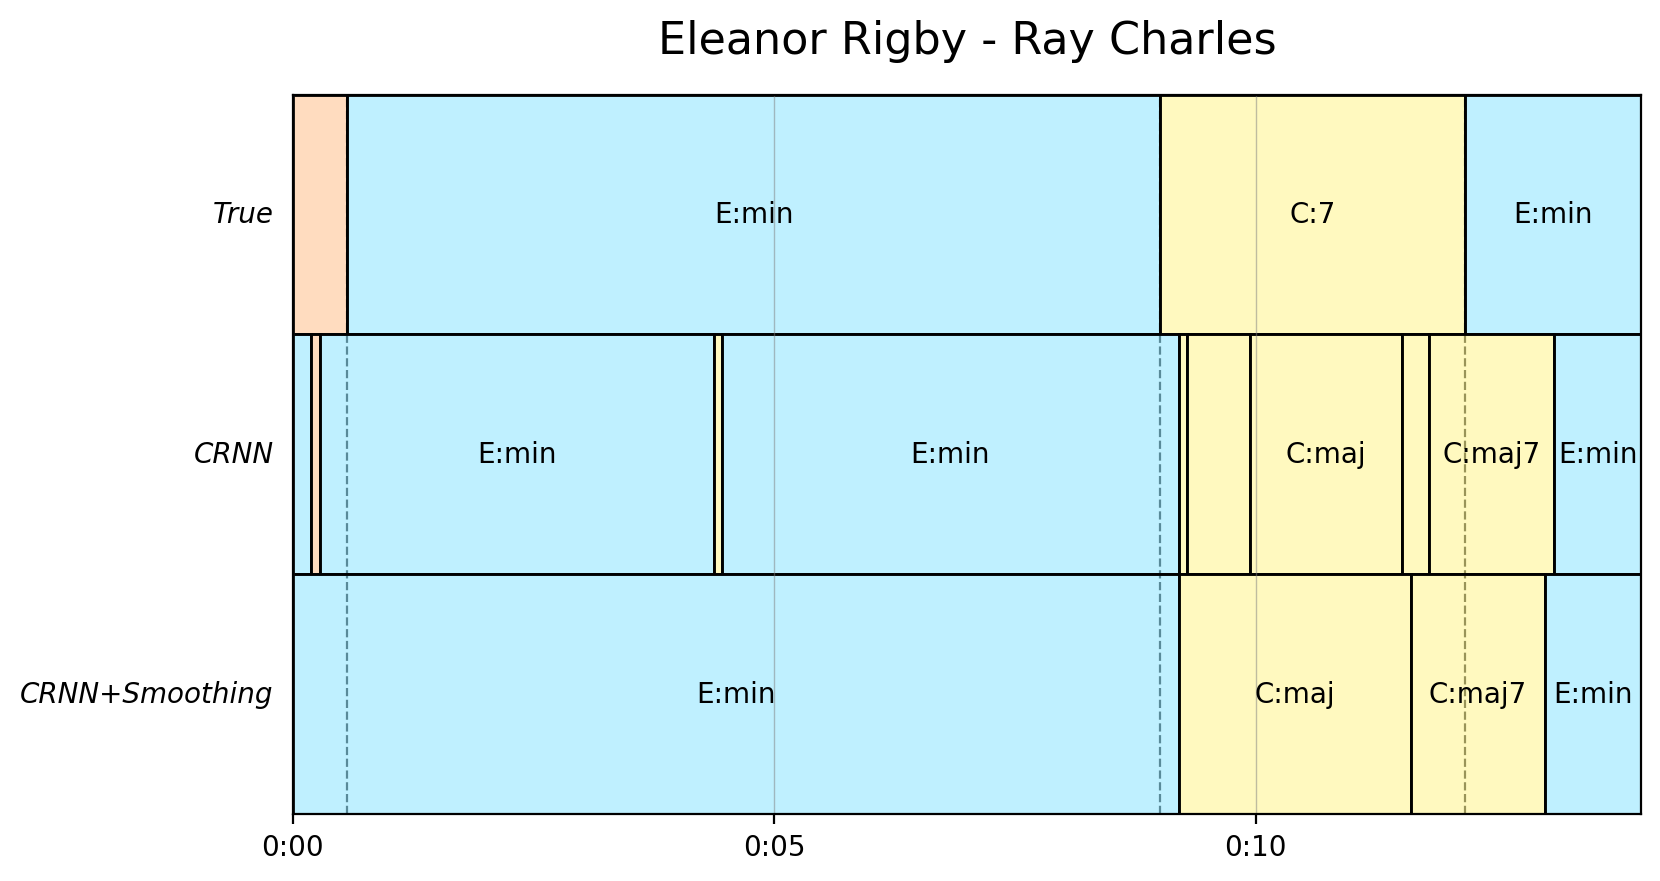

In [73]:
plot_chord_block(
    {
        "True": true_chords,
        "CRNN": preds,
        "CRNN+Smoothing": preds_smooth
    },
    window=(0, 14),
    width_per_second=0.6,
    title="Eleanor Rigby - Ray Charles",
    draw_chord_change_lines=True,
    save_as='hmm_smoothing_example',
    seed=5
)


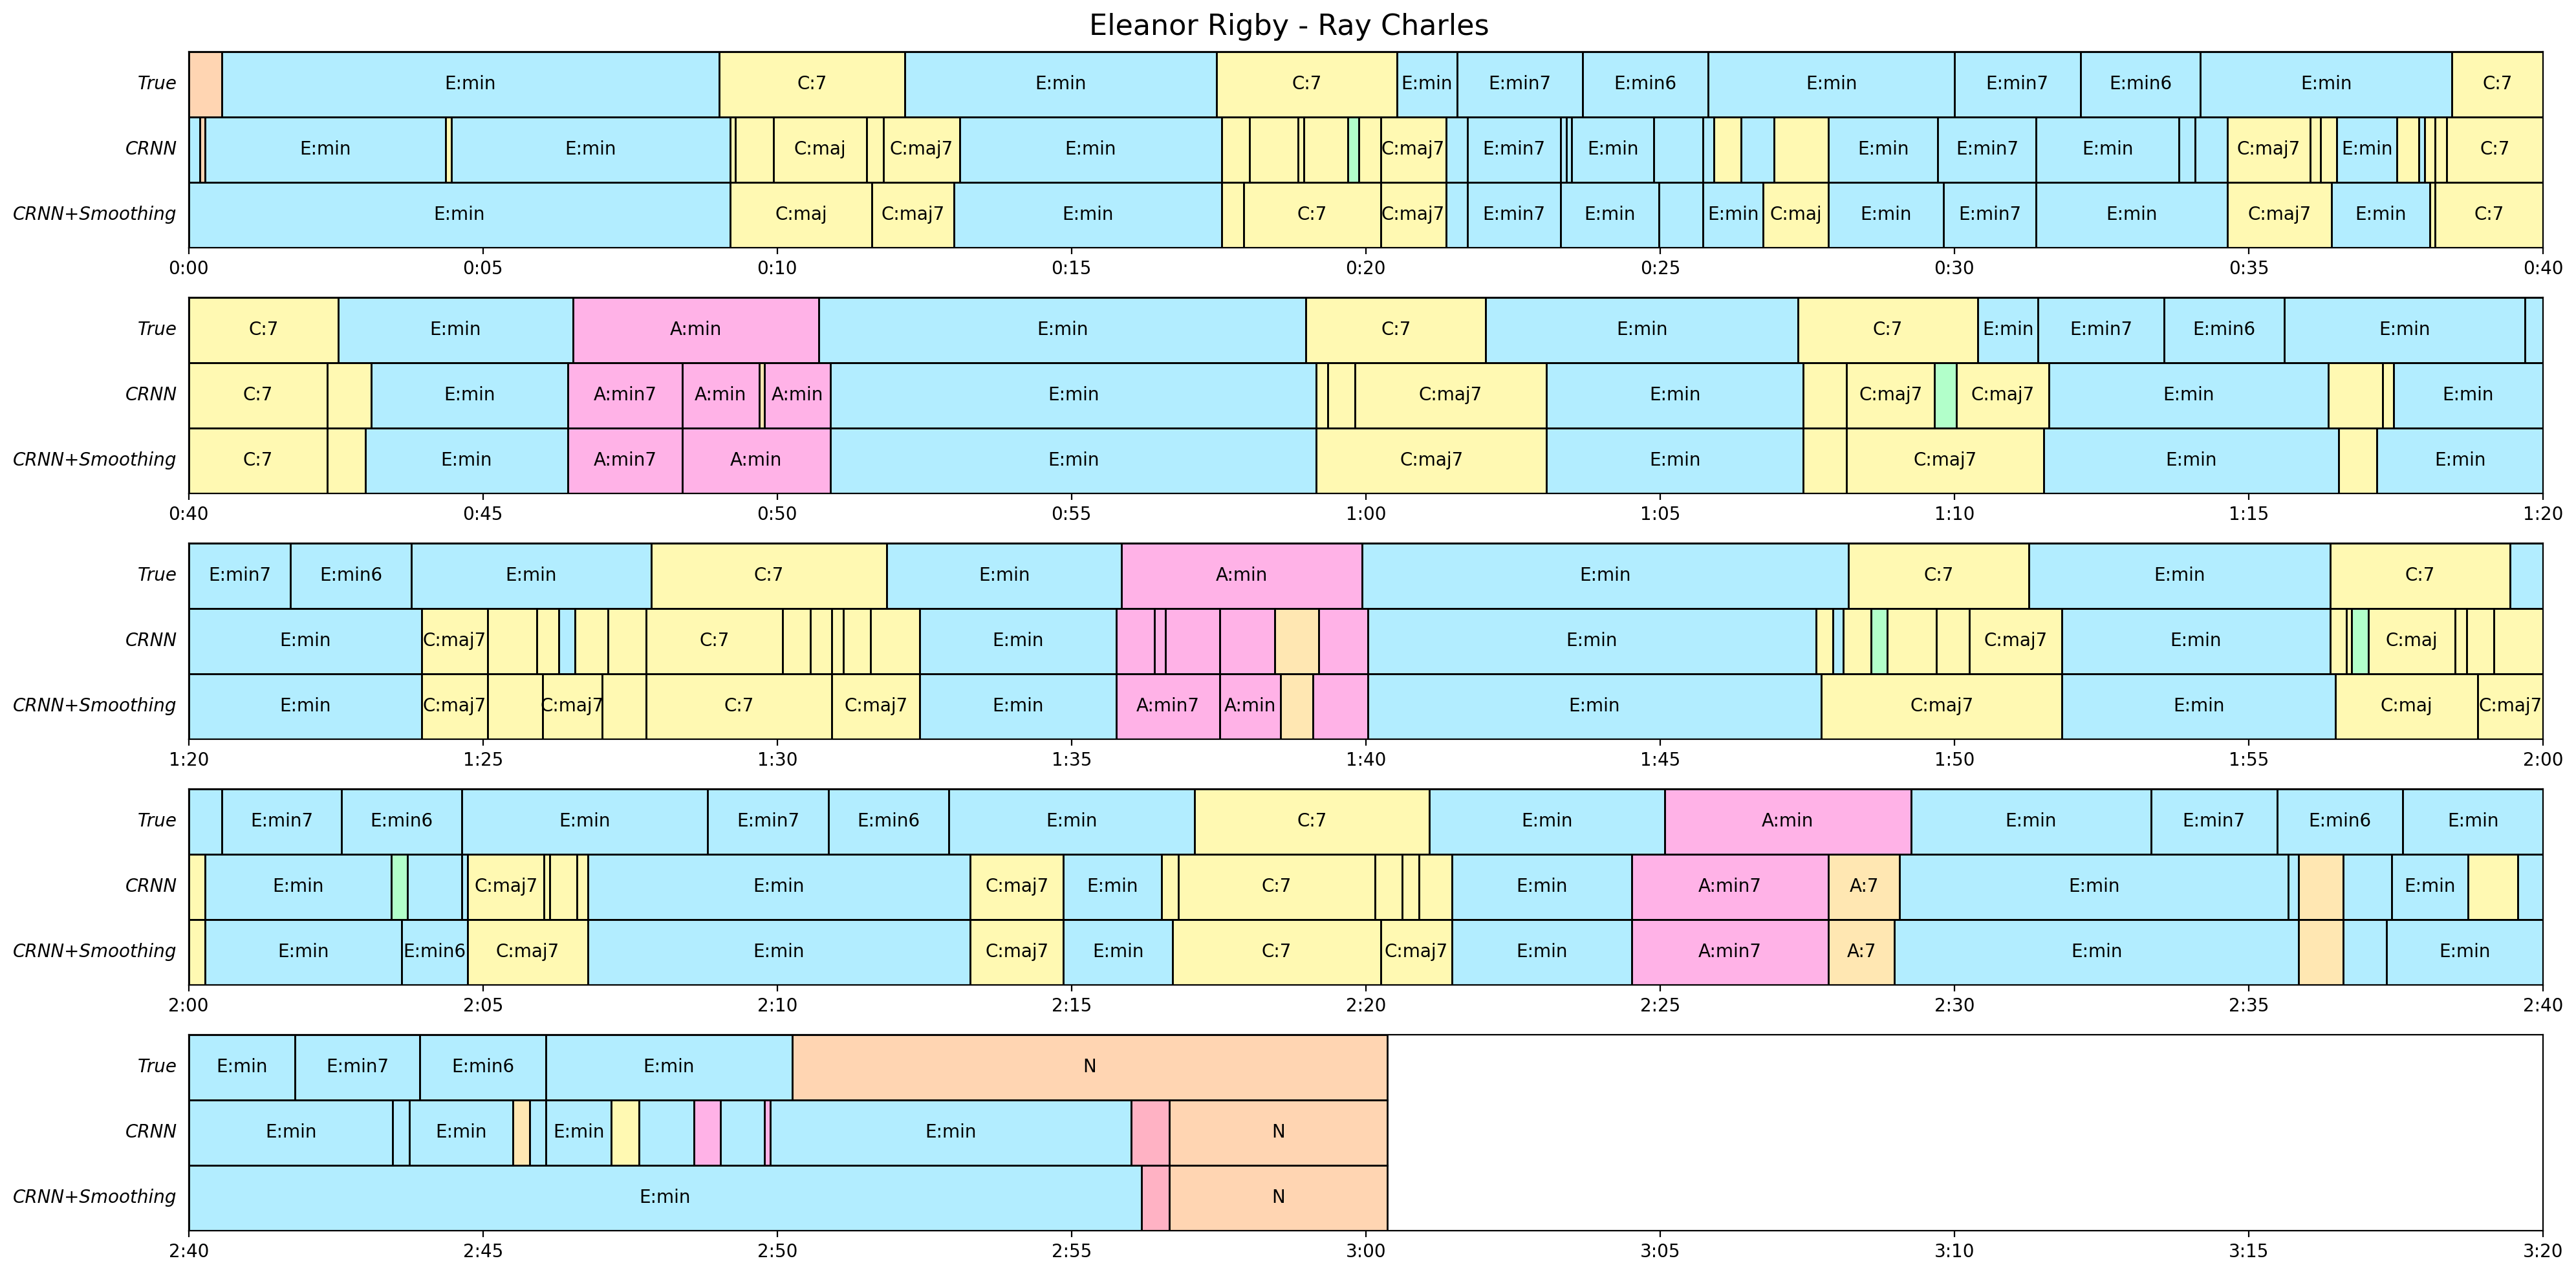

In [72]:
plot_chord_block_wrapped(
    {
        "True": true_chords,
        "CRNN": preds,
        "CRNN+Smoothing": preds_smooth
    },
    title="Eleanor Rigby - Ray Charles",
    max_time_per_row=40,
    width_per_second=0.5,
    seed=5
)